Deep Neural network based estimation for S and P wave arrival time
==

In [1]:
%matplotlib inline

In [2]:
# visualizacion
import matplotlib.pylab as plt
import seaborn as sns
sns.set(style="ticks")

In [3]:
# librerias cientificas basicas de python
import numpy as np # matrix operations
import pandas as pd # dataframes
from os import listdir # dir handler
from os.path import isfile, join # file operations
from tqdm import tqdm
from progress import log_progress #barra de progreso

# libreria de redes neuronales
from keras.models import Sequential
from keras.layers import Dense

# libreria sismica desarrollada
import sys
sys.path.append('./../python-packages')
from seismic_source import SeismicEvent

Using Theano backend.


Este es un ejemplo de señal sísmica para el campo de desplazamiento, la linea azul más a la izquiera es el tiempo de llegada de la onda $P$ y la linea vertical más a la derecha es el tiempo de llegada de la onda $S$.

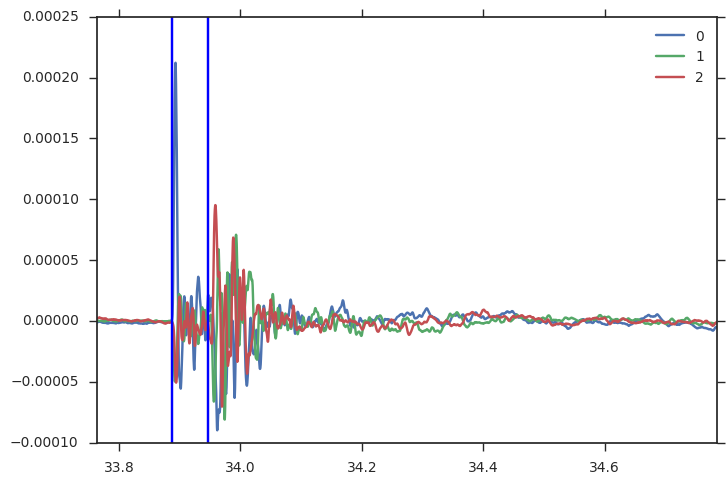

In [4]:
e = SeismicEvent.evento("../data-sets/1998_aug_07_16_24_33.i6b")
seis_info = e.seismograms[6]
seis_info.data.plot()
plt.axvline(x=seis_info.data.index[seis_info.P_pick])
plt.axvline(x=seis_info.data.index[seis_info.S_pick])

Algoritimo de Aprendizaje Supervidado Estimación de la llegada de la onda P y S
==

Luego de la captura de los datos es necesario de esta señal estimar el tiempo de llegada de la onda $P$ y la onda $S$ correspondiente respectivamente a la onda transversar y longitudinal del sismo. Se hace una estimación manual de cada uno de los sismogramas dado que para el ojo humano es más o menos simple determinar cual es el tiempo de llegada de la onda $P$ y la onda $S$. El verdadero problema es buscar una forma de automatizar este proceso, por lo podemos valernos de las señales antiguas en la que ya se hizo la estimación de la onda $S$ y la onda $P$ para entrenar un algoritmo de Machine Learning que aprenda a estimar estos valores.

#3 Problema de la representación de los datos


Usaremos una red neuronal para estimar el tiempo de llegada de la onda P y S

## construcción de los datos de entrenamiento
A partir de la información manual proveniente de codelco, entrenamos una red neuronal para estimar el tiempo de llegada de la onda S y la onda P. El primer paso es contruir los datos de entrenamiento. La cantidad de eventos sísmicos almacenados son del orden de 161.

In [5]:
%%time
mypath = "../data-sets"
trainning_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

print len(trainning_files)
u = int(0.7*len(trainning_files))

validation_files = list(set(trainning_files) - set(trainning_files[0:u]))
trainning_files = trainning_files[0:u]

161
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.99 ms


In [6]:
"""
Objetivo: Generar los datos de entrenamiento
Secuencia de pasos

0. Seleccionar un sismograma de un evento sismico
1. Agregar columnas con un cumsum del cuadrado de los datos dividido por el maximo del cumsum
   de los cuadrados de los datos que representa el porcentaje de energía en el tiempo
   (información global)
2. Seleccionar los datos del sismograma
3. Generar una columna indicando el indice en donde ocurre la llegada de la onda P
4. Generar una columna indicando el indice en donde ocurre la llegada de la onda S
5. eliminar el indice temporal para generar un indice autoincremental
6. Seleccionar un ancho de ventana de datos para el input de la red
7. Separar las entradas y las salidas en los datos de entrenamiento
"""
X = []
Y = []                                                                       # (7)
n = 500                                                                      # (6)

for t in log_progress(trainning_files):
    e = SeismicEvent.evento("../data-sets/" + t)
    for i, seismogram in enumerate(e.seismograms):

        data = seismogram.data                                               # (1)
        data['Energy'] = (data**2).cumsum().sum(axis=1)                      # (2)
        p_indicator = np.zeros(data.shape[0])
        p_indicator[seismogram.P_pick] = 1 
        p_df = pd.DataFrame(data= p_indicator, index=data.index) 
        data['p'] = p_df                                                     # (3)

        s_indicator = np.zeros(data.shape[0])
        s_indicator[seismogram.S_pick] = 1 
        s_df = pd.DataFrame(data= s_indicator, index=data.index) 
        data['s'] = s_df                                                    # (4)

        data.index = pd.DataFrame(range(data.index.values.shape[0]))        # (5)

        N = data.shape[0]
        for i in np.arange(N - n):
            case = data[i:(i + n)]
            x = np.hstack((case[0].values,
                           case[1].values,
                           case[2].values,
                           case['Energy'].values))
            
            y = np.hstack((case.p.sum(), case.s.sum()))
            X.append(x)
            Y.append(y)

In [ ]:
X = np.vstack(X)
Y = np.vstack(Y)
np.save(file='./X_train', arr = X)
np.save(file='./Y_train', arr = Y)

In [ ]:
X.shape

## Lectura de los datos de entrenamiento

Almacenamos los datos para ese largo de ventana específico

In [ ]:
X = np.load(file='./X_train.npy')
Y = np.load(file='./Y_train.npy')

In [6]:
print X.shape
print Y.shape

(847091, 302)
(847091, 300)
(847091, 2)


In [ ]:
## Preguntas de investigación



In [15]:
model = Sequential()
model.add(Dense(X.shape[1], input_dim=X.shape[1], init='uniform', activation='softmax'))
model.add(Dense(X.shape[1], init='uniform', activation='softmax'))
model.add(Dense(X.shape[1], init='uniform', activation='softmax'))
model.add(Dense(X.shape[1], init='uniform', activation='softmax'))
model.add(Dense(X.shape[1], init='uniform', activation='softmax'))
model.add(Dense(X.shape[1], init='uniform', activation='softmax'))
model.add(Dense(X.shape[1], init='uniform', activation='softmax'))
model.add(Dense(X.shape[1], init='uniform', activation='softmax'))
model.add(Dense(Y.shape[1], init='uniform', activation='sigmoid'))

In [16]:
model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [ ]:
model.fit(X, Y, nb_epoch=10, batch_size=10)

Epoch 1/10
 20430/847091 [..............................] - ETA: 1458s - loss: nan - acc: 0.0000e+00

In [ ]:
model.save_weights('./model_weights.h5')

In [ ]:
X.shape[1]

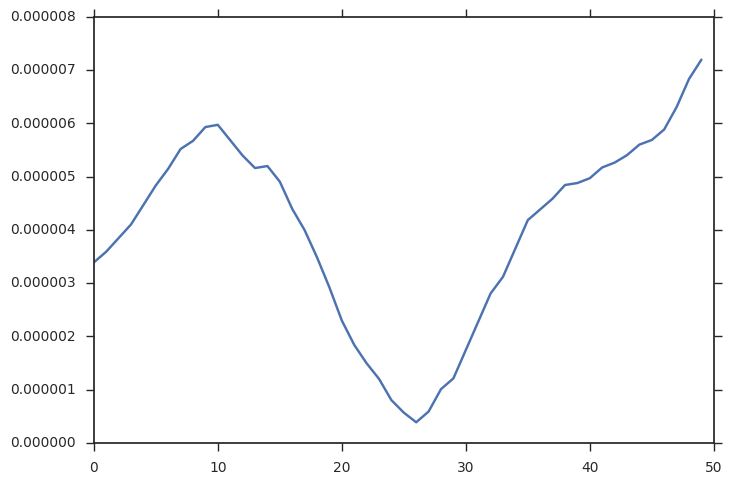

In [59]:
x = X[200,0:n]
plt.plot(x)

In [20]:
#x = x.reshape((1,300))
print 'evaluando la red'
predictions = model.predict(x)

#plt.plot(predictions)

evaluando la red


NameError: name 'x' is not defined

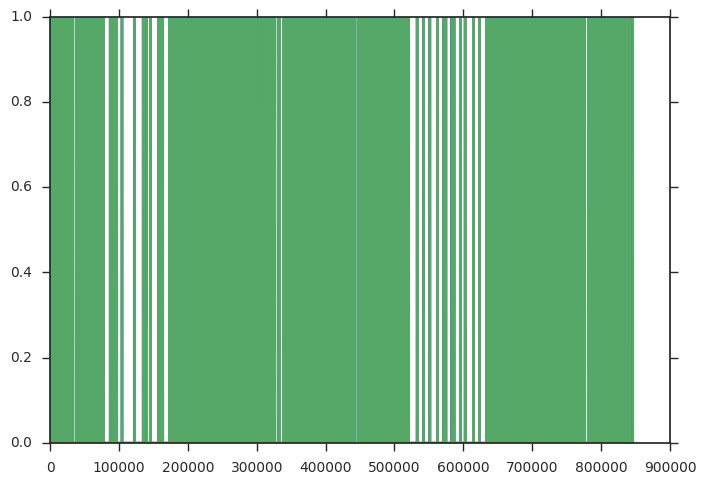

In [20]:
plt.plot(Y)

In [2]:
from ipywidgets import FloatProgress
from IPython.display import display

In [3]:
f = FloatProgress(min=0, max=100)
display(f)

In [4]:
import ipywidgets as widgets
widgets.HTML(value="Hello <b>World</b>")